#### 該文件包含1,338個案例，即目前已經登記過的保險計劃受益者、病人特點和計劃計入的總Medical Fee特徵:

* age:表示主要受益者年齡
* sex:性別
* bmi:身體質量指數,理想BMI在18.5~24.9之間
* children:表示保險計劃中所包括的孩子/受撫養者的數量
* smoker:表示被保險人是否經常吸煙
* region:受益者在美國的居住地-東北(northeast), 東南(sotheast), 西南(southwest)和東北(northwest)
* charges:Medical Fee

#### 目的:檢測與醫療費用相關之變量，找出在Medical Fee上具高風險的人

In [1]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter

# from sklearn.datasets import load_boston
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 1. 載入資料
df = pd.read_csv('insurance.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'insurance.csv'

In [ ]:
df.head()
#df.isnull().sum()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
#用 pandas 的 get_dummies 函數，把 df 裡面的 sex、smoker 和 region 這三個類別型變數 (categorical variables)，轉換成 one-hot encoding。
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'])
# 把所有資料型別轉成 int 型態
df_encoded = df_encoded.astype(int)
df_encoded

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27,0,16884,1,0,0,1,0,0,0,1
1,18,33,1,1725,0,1,1,0,0,0,1,0
2,28,33,3,4449,0,1,1,0,0,0,1,0
3,33,22,0,21984,0,1,1,0,0,1,0,0
4,32,28,0,3866,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30,3,10600,0,1,1,0,0,1,0,0
1334,18,31,0,2205,1,0,1,0,1,0,0,0
1335,18,36,0,1629,1,0,1,0,0,0,1,0
1336,21,25,0,2007,1,0,1,0,0,0,0,1


### 資料探索分析 (EDA) 

資料集基本資訊：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

描述性統計：
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000 

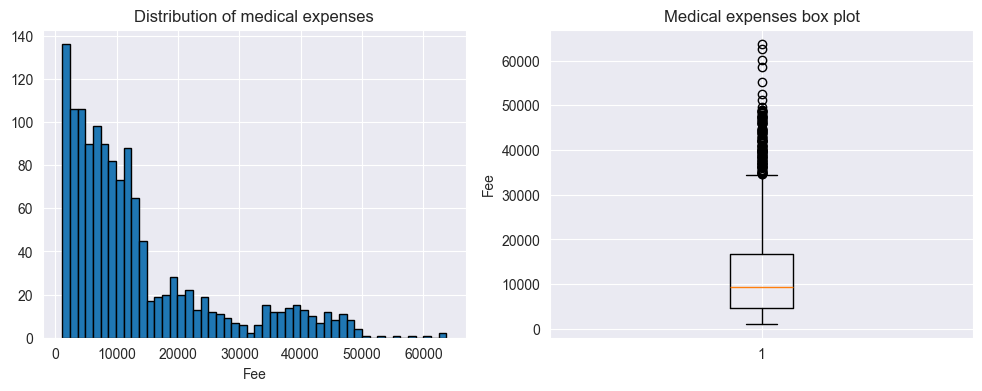

In [ ]:
# 建議新增以下分析
import matplotlib.pyplot as plt
import seaborn as sns

# 基本統計資訊
print("資料集基本資訊：")
print(df.info())
print("\n描述性統計：")
print(df.describe())

# 檢查缺失值
print("\n缺失值檢查：")
print(df.isnull().sum())

# 目標變數分布
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['charges'], bins=50, edgecolor='black')
plt.title('Distribution of medical expenses')
plt.xlabel('Fee')

plt.subplot(1, 2, 2)
plt.boxplot(df['charges'])
plt.title('Medical expenses box plot')
plt.ylabel('Fee')
plt.show()


## 標準化
* 當數據集中的不同特徵之間的尺度差異很大時，擬合的線性迴歸模型可能會受到影響，因為較大的特徵尺度可能會支配著較小的特徵尺度。
* 在這種情況下，標準化可以幫助線性迴歸模型更好地捕捉特徵之間的關係，提高模型的準確性和穩定性。
* 如果特徵之間的尺度差異較小，則標準化可能不是必要的。在這種情況下，可以直接使用原始數據進行線性迴歸建模。
* 在某些情況下，標準化可能會導致特徵之間的相關性變弱，因此需要根據具體的數據集和問題來決定是否需要進行標準化。

In [ ]:
from sklearn import preprocessing

# MinMaxScaler = 數值正規化方法，把數值特徵 (numerical features) 壓縮到 [0, 1] 的範圍
minmax = preprocessing.MinMaxScaler()

#指定資料表裡要正規化的數值型欄位名稱，放進一個 list
numeric_features = ['age', 'bmi', 'children']

#用 fit_transform() 來計算該欄位的最大值與最小值（fit），然後依照公式做數值正規化（transform)
#把正規化後的數值直接取代原來的資料

df_encoded[numeric_features] = minmax.fit_transform(df_encoded[numeric_features])

# 4. 建立最終的 DataFrame（這就是您的 df_final）
df_final = df_encoded.copy()

In [ ]:
df_final

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.315789,0.0,16884,1,0,0,1,0,0,0,1
1,0.000000,0.473684,0.2,1725,0,1,1,0,0,0,1,0
2,0.217391,0.473684,0.6,4449,0,1,1,0,0,0,1,0
3,0.326087,0.184211,0.0,21984,0,1,1,0,0,1,0,0
4,0.304348,0.342105,0.0,3866,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.695652,0.394737,0.6,10600,0,1,1,0,0,1,0,0
1334,0.000000,0.421053,0.0,2205,1,0,1,0,1,0,0,0
1335,0.000000,0.552632,0.0,1629,1,0,1,0,0,0,1,0
1336,0.065217,0.263158,0.0,2007,1,0,1,0,0,0,0,1


In [ ]:
# 特徵變數 X 應該是 df_final 中除了 'charges' 以外的所有欄位
# 使用 .drop() 方法是最安全明確的做法
X = df_final.drop('charges', axis=1).values

# 目標變數 y 保持不變，就是 'charges' 欄位
# 為了統一，建議也從 df_final 取值
y = df_final['charges'].values.reshape(-1, 1)

# 分割訓練和測試
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)

In [ ]:
print(f"Shape of X_train:{X_train.shape}")
print(f"Shape of X_test:{X_test.shape}")
print(f"Shape of y_train:{y_train.shape}")
print(f"Shape of y_test{y_test.shape}")
# 檢查 df_final 的欄位結構
print("df_final 的欄位：")
print(df_final.columns.tolist())
print(f"總共有 {len(df_final.columns)} 個欄位")
print(f"X 的形狀: {X.shape}")

# 檢查前11個欄位是什麼
print("\n前11個欄位（您的特徵變數）：")
for i in range(11):
    if i < len(df_final.columns):
        print(f"{i}: {df_final.columns[i]}")

Shape of X_train:(936, 11)
Shape of X_test:(402, 11)
Shape of y_train:(936, 1)
Shape of y_test(402, 1)
df_final 的欄位：
['age', 'bmi', 'children', 'charges', 'sex_female', 'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
總共有 12 個欄位
X 的形狀: (1338, 11)

前11個欄位（您的特徵變數）：
0: age
1: bmi
2: children
3: charges
4: sex_female
5: sex_male
6: smoker_no
7: smoker_yes
8: region_northeast
9: region_northwest
10: region_southeast


##  使用 DataFrame 進行 Pairplot

<Figure size 1500x1200 with 0 Axes>

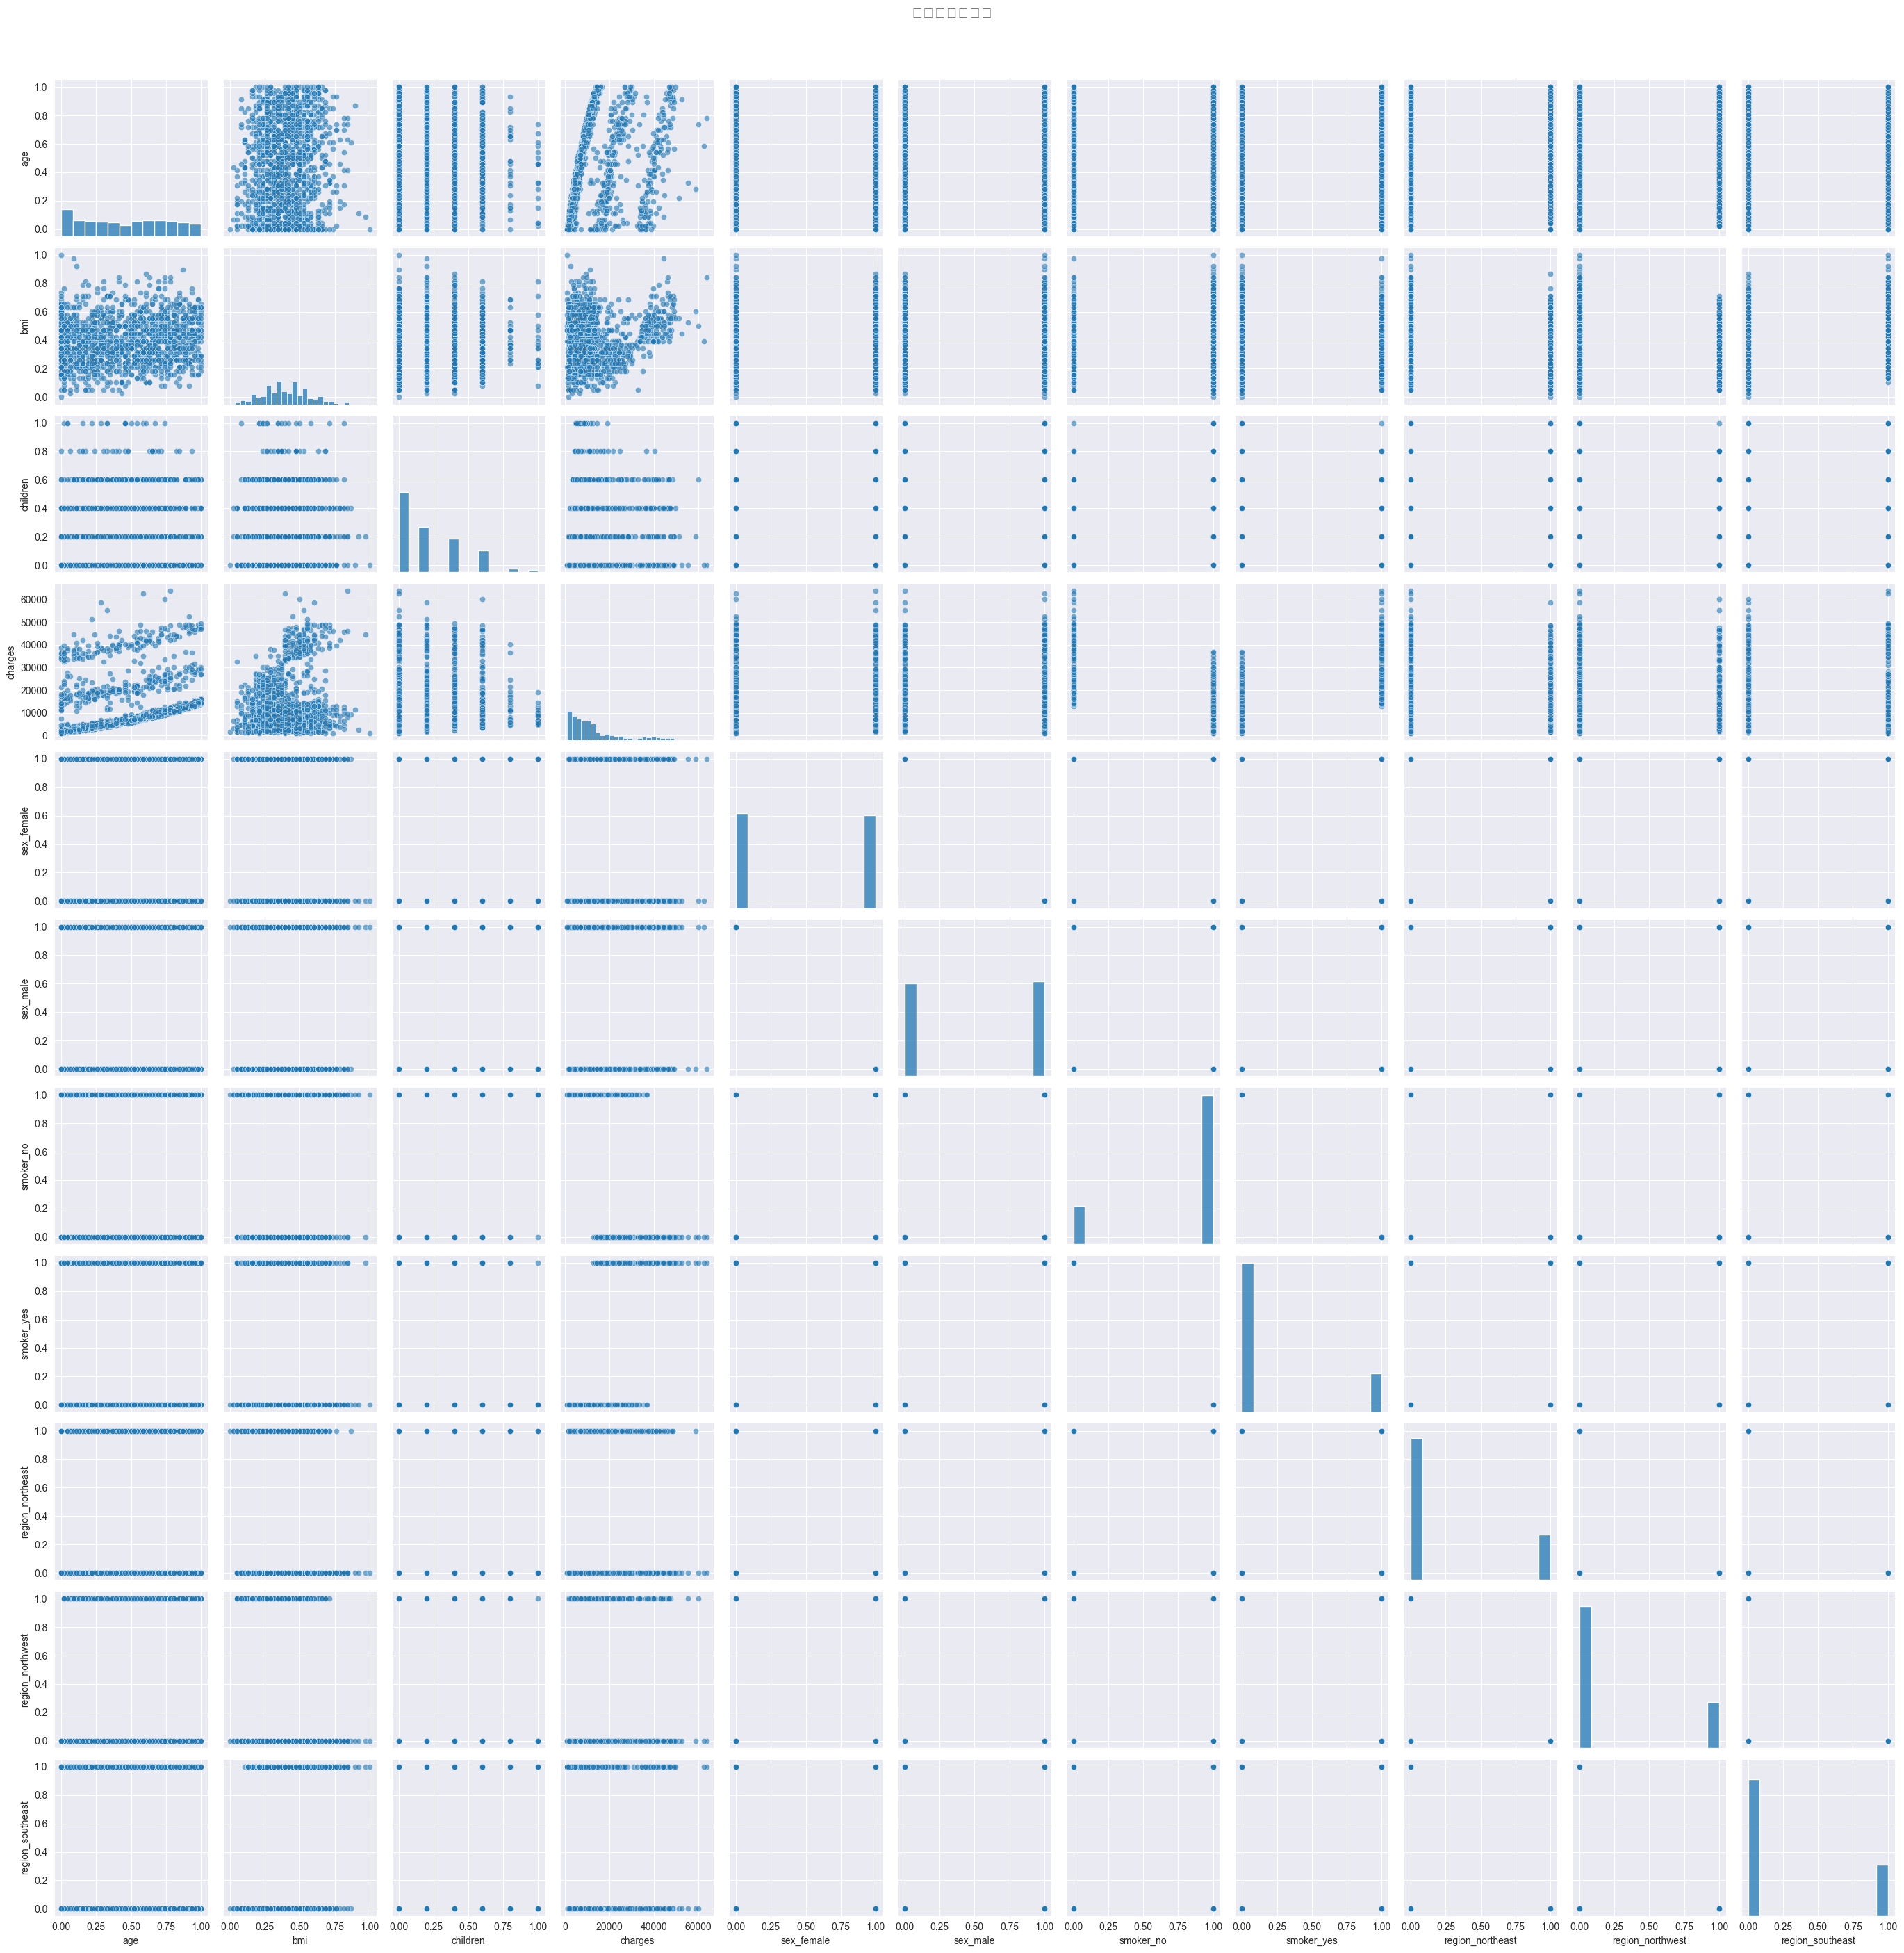

In [ ]:
# 建立包含特徵變數的 DataFrame
feature_names = df_final.columns[:11].tolist()  # 取前11個欄位名稱
#feature_names = ['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']

#把之前從 df_final.iloc[:, 0:11].values 取出來的 numpy 陣列 X，包成一個新的 DataFrame
#columns=feature_names 👉 指定這個 DataFrame 的欄位名稱，就是上面那個 feature_names list
X_df = pd.DataFrame(X, columns=feature_names)

# 基本 pairplot
plt.figure(figsize=(15, 12))
sns.pairplot(X_df, diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle('特徵變數配對圖', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# 4. Correlation
### <span style="color:#3498DB">Point1: 請觀察各變數之間的關係</span>
### <span style="color:#3498DB">Point2: 請判斷各變數之間是否有共線關係</span>

# 相關性分析

與Medical Fee相關性排序：
charges             1.000000
smoker_no           0.787251
smoker_yes          0.787251
age                 0.299009
bmi                 0.196188
region_southeast    0.073981
children            0.067999
sex_female          0.057293
sex_male            0.057293
region_southwest    0.043210
region_northwest    0.039905
region_northeast    0.006350
Name: charges, dtype: float64


<Axes: >

<Figure size 1500x1200 with 0 Axes>

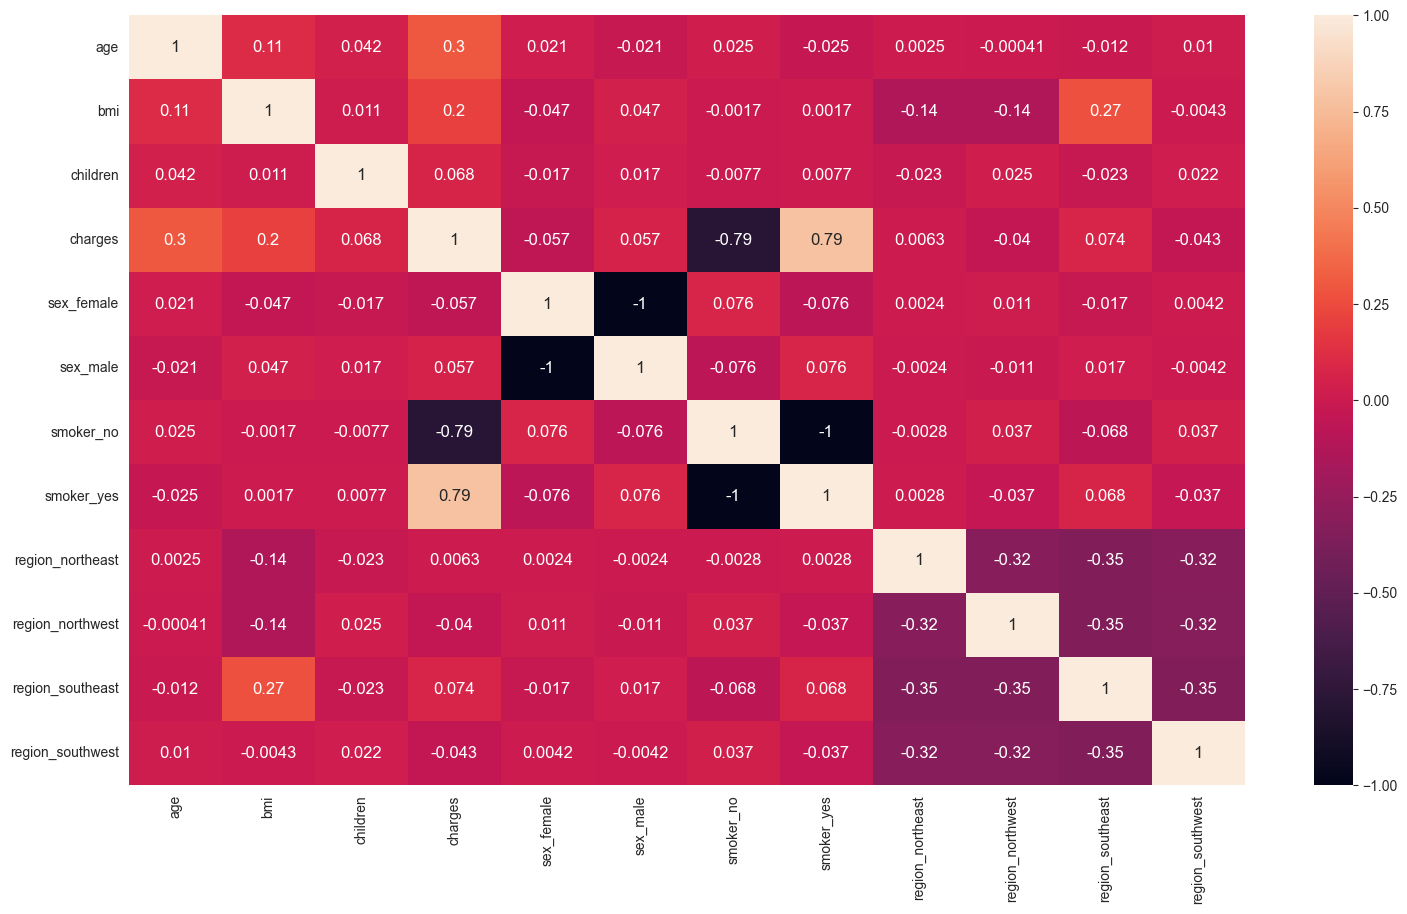

In [ ]:
plt.figure(figsize=(15, 12))
corrmat = df_encoded.corr()
target_corr = corrmat['charges'].abs().sort_values(ascending=False)
print("與Medical Fee相關性排序：")
print(target_corr)
fig, ax = plt.subplots(figsize = (18, 10))
sns.heatmap(corrmat, annot = True, annot_kws={'size': 12})

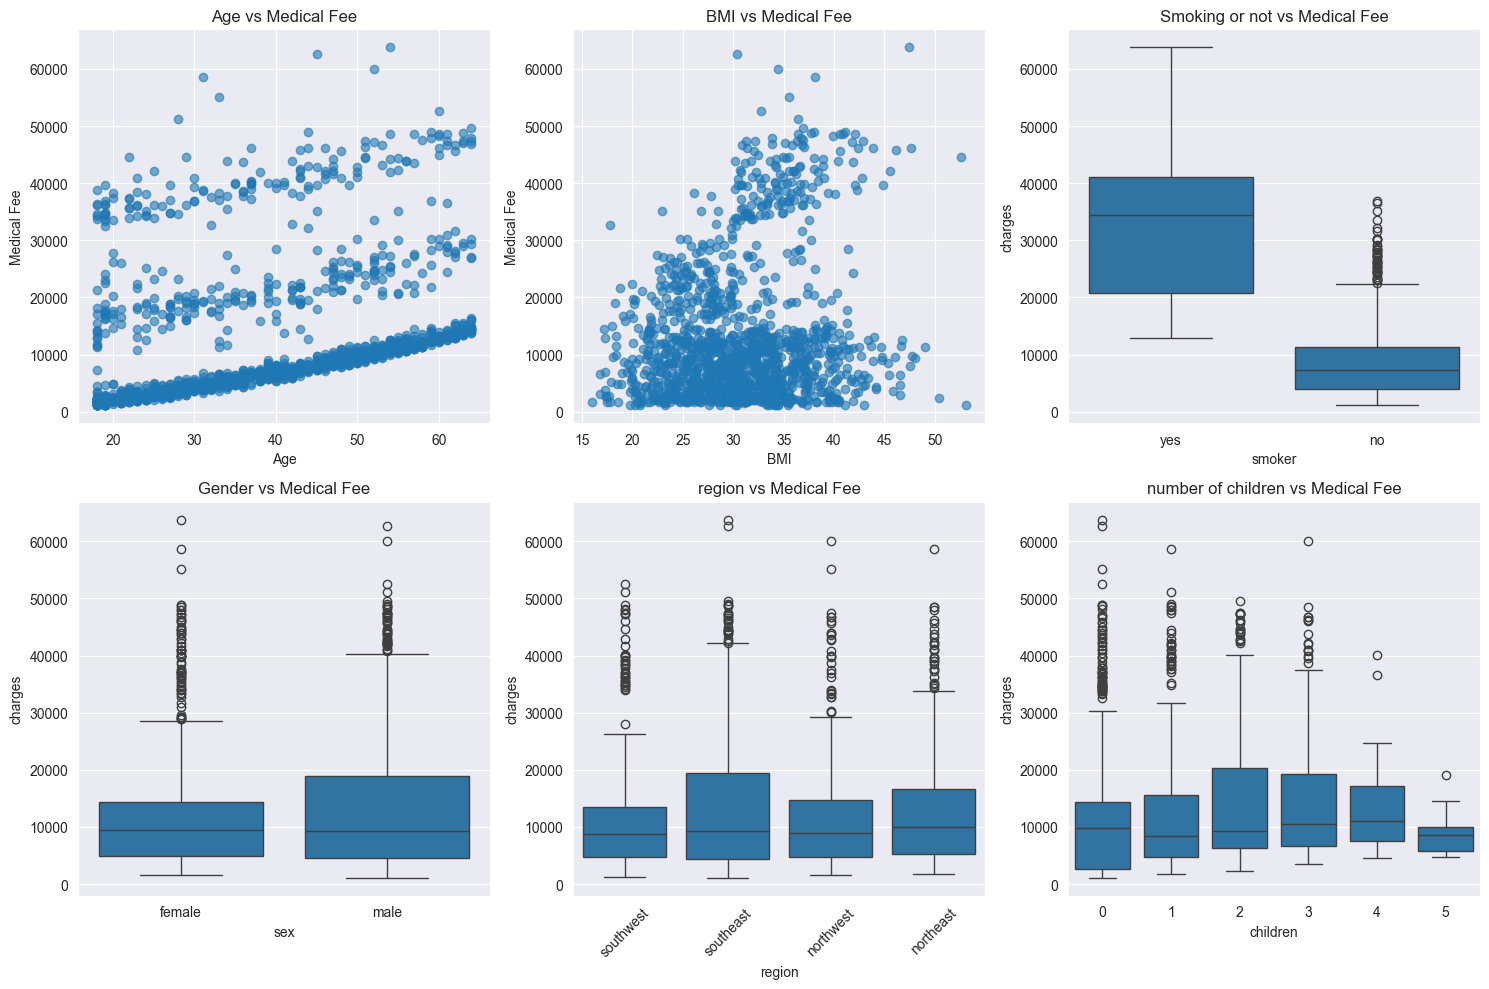

In [ ]:
# 分析各特徵對醫療費用的影響
plt.figure(figsize=(15, 10))

# 年齡 vs 費用
plt.subplot(2, 3, 1)
plt.scatter(df['age'], df['charges'], alpha=0.6)
plt.xlabel('Age')
plt.ylabel('Medical Fee')
plt.title('Age vs Medical Fee')

# BMI vs 費用
plt.subplot(2, 3, 2)
plt.scatter(df['bmi'], df['charges'], alpha=0.6)
plt.xlabel('BMI')
plt.ylabel('Medical Fee')
plt.title('BMI vs Medical Fee')

# 吸煙 vs 費用
plt.subplot(2, 3, 3)
sns.boxplot(data=df, x='smoker', y='charges')
plt.title('Smoking or not vs Medical Fee')

# 性別 vs 費用
plt.subplot(2, 3, 4)
sns.boxplot(data=df, x='sex', y='charges')
plt.title('Gender vs Medical Fee')

# 地區 vs 費用
plt.subplot(2, 3, 5)
sns.boxplot(data=df, x='region', y='charges')
plt.title('region vs Medical Fee')
plt.xticks(rotation=45)

# 子女數量 vs 費用
plt.subplot(2, 3, 6)
sns.boxplot(data=df, x='children', y='charges')
plt.title('number of children vs Medical Fee')

plt.tight_layout()
plt.show()


In [ ]:
## 5-1 Linear Regression (PPT 1.1 & 1.2)

In [ ]:
from sklearn.linear_model import LinearRegression
regressor_linear = LinearRegression()
regressor_linear.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
from sklearn.metrics import r2_score

# R2 score，即決定係數，反映Y的全部變異能通過迴歸關係被所有X解釋的比例。
y_pred_linear_train = regressor_linear.predict(X_train)
r2_score_linear_train = r2_score(y_train, y_pred_linear_train)

y_pred_linear_test = regressor_linear.predict(X_test)
r2_score_linear_test = r2_score(y_test, y_pred_linear_test)

# RMSE一般指均方根誤差(標準誤差)，可衡量預測值和實際值之間的平均差異，藉此估計預測模型預測目標值的準確度
rmse_train = (np.sqrt(mean_squared_error(y_train, y_pred_linear_train)))
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_linear_test)))

print('R2_score (train): ', r2_score_linear_train)
print('R2_score (test): ', r2_score_linear_test)
print("RMSE: ", rmse_train)
print("RMSE: ", rmse_test)

R2_score (train):  0.9999999994608879
R2_score (test):  0.9999999994590105
RMSE:  0.2801655062700165
RMSE:  0.2836183931345437
